# Appendix Experiments

## Crosshatch

In [42]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.cleandiffuser.classifier import CumRewClassifier
from utilities.cleandiffuser.nn_classifier import HalfJannerUNet1d
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
plt.rcParams["font.family"] = "Times New Roman"

# start and end goal     # 2,0 -> 2,5 should be a novel S-A pair
start_idx = (0,5)
goal_idx = (5,4)


#(2, 0) (2, 5)
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 1
num_episodes = 1
temperature = 0.5
n_exec_steps = 512
render = True
goal_inpaint_steps = 25

# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs,goal_cond=True)
env = GridLand(n_size=5,timeout = 500)
 
env.reset(start_idx=start_idx,goal_idx=goal_idx)

(array([-0.96,  0.96]),
 {'goal': array([0.96 , 0.576]),
  'keypoints': array([-0.96 , -0.576, -0.192,  0.192,  0.576,  0.96 ])})

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:05<00:00,  5.68s/it]

Avg. Completion: 0.0
# of Training Trajectory Repeats 0
# of Unique Generated Trajectories: 1
# of New Generated Trajectories: 1
% of Generated Trajectories Novel: 1.0
# of Unique Generated Successful Trajectories: 0


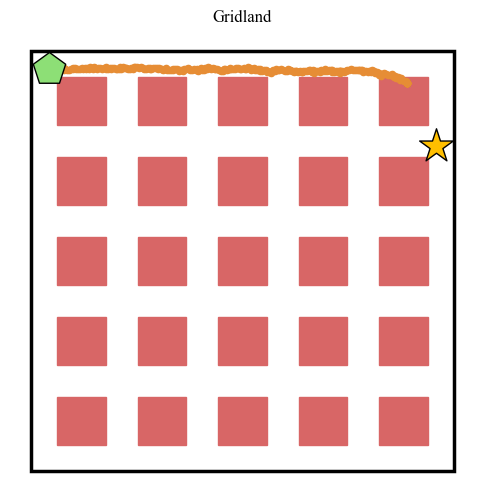

In [43]:
### Eq-Net, Unconditional
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.goal_inpaint_steps = goal_inpaint_steps
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = 512
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = True
config.add_positional_encoding = False


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
#agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
#agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

#agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

#agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
#agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

agent.load('appendix_models/DP-EqNet-KL-gridland-n5-69af12dadiffusion_ckpt_latest.pt')
# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1 and n_exec_steps != 512:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
#ax.legend()
fig.set_dpi(100)

traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
reproduced_training_trajectories = 0
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
                # stuff
                this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                if len(this_trajectory_set & training_trajectory_visitations) !=0:
                        reproduced_training_trajectories += 1
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
print('# of Training Trajectory Repeats',reproduced_training_trajectories)
print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
#print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
#print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

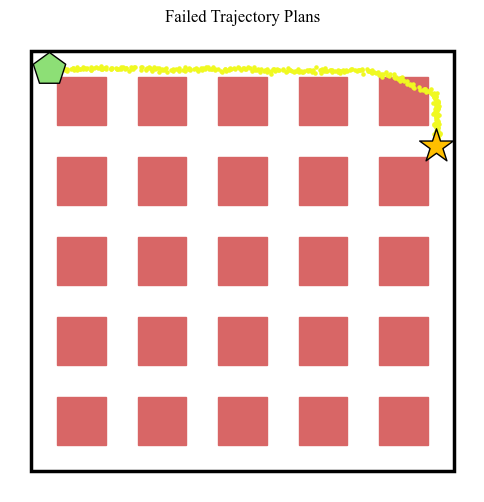

In [44]:
# looking at teailures
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Failed Trajectory Plans')
failed_trajectories = generated_trajectory_visitations - (filtered_trajectories | training_trajectory_visitations)
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        

## Memory Experiments

In [8]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 100
num_samples = 8
num_episodes = 1 # try not to change this i haven't validated it works and suspect heavily that it does not 
temperature = 0.5
n_exec_steps = 50
render = True
visualize = False
# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
env = GridLand(n_size=5,timeout = 500)
env.reset()
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(50))
#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))
print('Total # of Env:',num_envs*num_samples)

Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 370326.58it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800


In [9]:
### overfitting stuff u-net with aug 
memory_amounts = [1,16,32,64,128,256,512]
for memory in tqdm(memory_amounts):
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = False
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = horizon
    config.toy_env = True
    config.open_loop_invdyn = False
    config.use_shift_equivariant_arch = False
    config.add_positional_encoding = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end' 

    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

    # loads inverse dynamics
    invdyn = ToyEnvInvDyn()
    #invdyn.load(config.invdyn_path)

    # loads agent 
    # --------------- Network Architecture -----------------# 
    #nn_diffusion = JannerUNet1dShiftEq(obs_dim)
    #nn_diffusion = ConvNext1dShiftEq(obs_dim)
    nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)


    # ----------------- Masking -------------------
    # NOTE - not sure what any of this does (should figure out!)
    fix_mask = torch.zeros((config.horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.horizon, obs_dim))

    # --------------- difuse --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion, None,
            fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
            device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


    #agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

    #agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')
    #agent.load('paper_models/DP-UNet-PosAug-gridland-n5-gc-e639f3f1diffusion_ckpt_latest.pt')
    agent.load('paper_models/DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_latest.pt')
    #agent.load('paper_models/' + model_paths[i])

    # Environment info 
    print('==== Unconditional EqNet  ====')
    print('Memory:',memory)
    print('Name:',config.env)
    print('Obs Space:',obs_dim)
    print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    avg_completion = 0
    trajectories = []
    for i in range(num_samples):
            envs.reset()
            avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
            # pads trajectory samples to 512
            new_trajectory_samples = []
            for traj in trajectories_sample:
                    new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                    #print(new_traj.shape)
                    new_trajectory_samples.append(new_traj)
            avg_completion += avg_completion_sample
            trajectories += new_trajectory_samples
    avg_completion = avg_completion / num_samples
    print('Avg. Completion:',avg_completion)

    if visualize:
            env = GridLand(n_size=n_size,timeout = 500)
            env.reset()
            fig, ax = env.get_mpl_plot()
            #print('replans',np.array(replans).shape)
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
            if num_envs == 1:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
            else:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
            #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


            if num_envs == 1:
                    if n_exec_steps != horizon:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            for i,replan in enumerate(replans[0]):
                                    #print(replan.shape)
                                    ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                    else:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                            fig.colorbar(thingy)


            #print(trajectories[0].shape)
                    visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
            #print(visited_intersections.shape)
                    ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
            ax.legend()
    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
    print(len(filtered_trajectories))
    print('# of Unique Generated Trajectories:',len(filtered_trajectories))
    print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    #print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations


  0%|          | 0/7 [00:00<?, ?it/s]

==== Unconditional EqNet  ====
Memory: 1
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:01<00:00, 61.72s/it]


Avg. Completion: 0.99875


 14%|█▍        | 1/7 [08:24<50:26, 504.40s/it]

154
# of Unique Generated Trajectories: 154
# of New Generated Trajectories: 113
==== Unconditional EqNet  ====
Memory: 16
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:08<00:00, 68.62s/it]


Avg. Completion: 0.945


 29%|██▊       | 2/7 [17:44<44:46, 537.37s/it]

139
# of Unique Generated Trajectories: 139
# of New Generated Trajectories: 101
==== Unconditional EqNet  ====
Memory: 32
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:07<00:00, 67.89s/it]


Avg. Completion: 0.43125


 43%|████▎     | 3/7 [27:00<36:23, 545.77s/it]

116
# of Unique Generated Trajectories: 116
# of New Generated Trajectories: 81
==== Unconditional EqNet  ====
Memory: 64
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:07<00:00, 67.93s/it]


Avg. Completion: 0.25875


 57%|█████▋    | 4/7 [36:19<27:32, 550.93s/it]

86
# of Unique Generated Trajectories: 86
# of New Generated Trajectories: 60
==== Unconditional EqNet  ====
Memory: 128
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:08<00:00, 68.53s/it]


Avg. Completion: 0.27625


 71%|███████▏  | 5/7 [45:38<18:27, 553.88s/it]

78
# of Unique Generated Trajectories: 78
# of New Generated Trajectories: 51
==== Unconditional EqNet  ====
Memory: 256
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:08<00:00, 68.10s/it]


Avg. Completion: 0.3925


 86%|████████▌ | 6/7 [54:52<09:14, 554.05s/it]

85
# of Unique Generated Trajectories: 85
# of New Generated Trajectories: 59
==== Unconditional EqNet  ====
Memory: 512
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:08<00:00, 68.59s/it]


Avg. Completion: 0.38750000000000007


100%|██████████| 7/7 [1:04:09<00:00, 549.94s/it]

82
# of Unique Generated Trajectories: 82
# of New Generated Trajectories: 53


## Overfitting Experiments

In [10]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 100
num_samples = 8
num_episodes = 1 # try not to change this i haven't validated it works and suspect heavily that it does not 
temperature = 0.5
n_exec_steps = 512
render = True
visualize = False
# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
env = GridLand(n_size=5,timeout = 500)
env.reset()
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(50))
#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))
print('Total # of Env:',num_envs*num_samples)

Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 389572.04it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800


In [ ]:
### overfitting stuff u-net default
model_paths = [
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_50000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_100000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_150000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_200000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_250000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_300000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_350000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_400000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_450000.pt',
                'DP-UNet-gridland-n5-37166c54diffusion_ckpt_500000.pt'
                ]
for i in range(len(model_paths)):
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = False
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = horizon
    config.toy_env = True
    config.open_loop_invdyn = False
    config.use_shift_equivariant_arch = False
    config.add_positional_encoding = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end' 

    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

    # loads inverse dynamics
    invdyn = ToyEnvInvDyn()
    #invdyn.load(config.invdyn_path)

    # loads agent 
    # --------------- Network Architecture -----------------# 
    #nn_diffusion = JannerUNet1dShiftEq(obs_dim)
    #nn_diffusion = ConvNext1dShiftEq(obs_dim)
    nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)


    # ----------------- Masking -------------------
    # NOTE - not sure what any of this does (should figure out!)
    fix_mask = torch.zeros((config.horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.horizon, obs_dim))

    # --------------- difuse --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion, None,
            fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
            device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


    #agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

    #agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')
    agent.load('paper_models/' + model_paths[i])

    # Environment info 
    print('==== Unconditional EqNet  ====')
    print('Model Path:',model_paths[i])
    print('Name:',config.env)
    print('Obs Space:',obs_dim)
    print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    avg_completion = 0
    trajectories = []
    for i in range(num_samples):
            envs.reset()
            avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
            # pads trajectory samples to 512
            new_trajectory_samples = []
            for traj in trajectories_sample:
                    new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                    #print(new_traj.shape)
                    new_trajectory_samples.append(new_traj)
            avg_completion += avg_completion_sample
            trajectories += new_trajectory_samples
    avg_completion = avg_completion / num_samples
    print('Avg. Completion:',avg_completion)

    if visualize:
            env = GridLand(n_size=n_size,timeout = 500)
            env.reset()
            fig, ax = env.get_mpl_plot()
            #print('replans',np.array(replans).shape)
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
            if num_envs == 1:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
            else:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
            #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


            if num_envs == 1:
                    if n_exec_steps != horizon:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            for i,replan in enumerate(replans[0]):
                                    #print(replan.shape)
                                    ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                    else:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                            fig.colorbar(thingy)


            #print(trajectories[0].shape)
                    visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
            #print(visited_intersections.shape)
                    ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
            ax.legend()
    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
    print(len(filtered_trajectories))
    print('# of Unique Generated Trajectories:',len(filtered_trajectories))
    print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations


==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_50000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.89s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_100000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_150000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_200000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:10<00:00, 10.59s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_250000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_300000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.36s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_350000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_400000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.14s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_450000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.22s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0
==== Unconditional EqNet  ====
Model Path: DP-UNet-gridland-n5-37166c54diffusion_ckpt_500000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.13s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0


In [13]:
### overfitting stuff u-net with aug
model_paths = [
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_50000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_100000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_150000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_200000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_250000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_300000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_350000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_400000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_450000.pt',
                'DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_500000.pt'
                ]
for i in range(len(model_paths)):
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = False
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = horizon
    config.toy_env = True
    config.open_loop_invdyn = False
    config.use_shift_equivariant_arch = False
    config.add_positional_encoding = False
    config.guidance = 'none'
    config.goal_sample_dist = 'end' 

    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

    # loads inverse dynamics
    invdyn = ToyEnvInvDyn()
    #invdyn.load(config.invdyn_path)

    # loads agent 
    # --------------- Network Architecture -----------------# 
    #nn_diffusion = JannerUNet1dShiftEq(obs_dim)
    #nn_diffusion = ConvNext1dShiftEq(obs_dim)
    nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)


    # ----------------- Masking -------------------
    # NOTE - not sure what any of this does (should figure out!)
    fix_mask = torch.zeros((config.horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.horizon, obs_dim))

    # --------------- difuse --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion, None,
            fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
            device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


    #agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

    #agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')
    agent.load('paper_models/' + model_paths[i])

    # Environment info 
    print('==== Unconditional EqNet  ====')
    print('Model Path:',model_paths[i])
    print('Name:',config.env)
    print('Obs Space:',obs_dim)
    print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    avg_completion = 0
    trajectories = []
    for i in range(num_samples):
            envs.reset()
            avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
            # pads trajectory samples to 512
            new_trajectory_samples = []
            for traj in trajectories_sample:
                    new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                    #print(new_traj.shape)
                    new_trajectory_samples.append(new_traj)
            avg_completion += avg_completion_sample
            trajectories += new_trajectory_samples
    avg_completion = avg_completion / num_samples
    print('Avg. Completion:',avg_completion)

    if visualize:
            env = GridLand(n_size=n_size,timeout = 500)
            env.reset()
            fig, ax = env.get_mpl_plot()
            #print('replans',np.array(replans).shape)
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
            if num_envs == 1:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
            else:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
            #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


            if num_envs == 1:
                    if n_exec_steps != horizon:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            for i,replan in enumerate(replans[0]):
                                    #print(replan.shape)
                                    ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                    else:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                            fig.colorbar(thingy)


            #print(trajectories[0].shape)
                    visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
            #print(visited_intersections.shape)
                    ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
            ax.legend()
    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
    print(len(filtered_trajectories))
    print('# of Unique Generated Trajectories:',len(filtered_trajectories))
    print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    #print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations


==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_50000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.18s/it]


Avg. Completion: 0.0
0
# of Unique Generated Trajectories: 0
# of New Generated Trajectories: 0
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_100000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.77s/it]


Avg. Completion: 0.9812500000000002
84
# of Unique Generated Trajectories: 84
# of New Generated Trajectories: 42
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_150000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.63s/it]


Avg. Completion: 0.9950000000000001
65
# of Unique Generated Trajectories: 65
# of New Generated Trajectories: 23
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_200000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.57s/it]


Avg. Completion: 0.9874999999999999
63
# of Unique Generated Trajectories: 63
# of New Generated Trajectories: 21
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_250000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.93s/it]


Avg. Completion: 0.9962500000000001
58
# of Unique Generated Trajectories: 58
# of New Generated Trajectories: 16
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_300000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.64s/it]


Avg. Completion: 0.9950000000000001
58
# of Unique Generated Trajectories: 58
# of New Generated Trajectories: 16
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_350000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.18s/it]


Avg. Completion: 0.9962500000000001
56
# of Unique Generated Trajectories: 56
# of New Generated Trajectories: 14
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_400000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.02s/it]


Avg. Completion: 0.9962500000000001
55
# of Unique Generated Trajectories: 55
# of New Generated Trajectories: 13
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_450000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.47s/it]


Avg. Completion: 0.9975
51
# of Unique Generated Trajectories: 51
# of New Generated Trajectories: 9
==== Unconditional EqNet  ====
Model Path: DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_500000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:11<00:00, 11.57s/it]


Avg. Completion: 0.99
53
# of Unique Generated Trajectories: 53
# of New Generated Trajectories: 11


In [14]:
### overfitging stuff Eq-Net
model_paths = [
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_50000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_100000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_150000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_200000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_250000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_300000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_350000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_400000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_450000.pt',
                'DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_500000.pt'
                ]
for i in range(len(model_paths)):
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = False
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = horizon
    config.toy_env = True
    config.open_loop_invdyn = False
    config.use_shift_equivariant_arch = True
    config.add_positional_encoding = True

    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

    # loads inverse dynamics
    invdyn = ToyEnvInvDyn()
    #invdyn.load(config.invdyn_path)

    # loads agent 
    # --------------- Network Architecture -----------------# 
    #nn_diffusion = JannerUNet1dShiftEq(obs_dim)
    #nn_diffusion = ConvNext1dShiftEq(obs_dim)
    nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)


    # ----------------- Masking -------------------
    # NOTE - not sure what any of this does (should figure out!)
    fix_mask = torch.zeros((config.horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.horizon, obs_dim))

    # --------------- difuse --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion, None,
            fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
            device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


    #agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

    #agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')
    agent.load('paper_models/' + model_paths[i])

    # Environment info 
    print('==== Unconditional EqNet  ====')
    print('Model Path:',model_paths[i])
    print('Name:',config.env)
    print('Obs Space:',obs_dim)
    print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    avg_completion = 0
    trajectories = []
    for i in range(num_samples):
            envs.reset()
            avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
            # pads trajectory samples to 512
            new_trajectory_samples = []
            for traj in trajectories_sample:
                    new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                    #print(new_traj.shape)
                    new_trajectory_samples.append(new_traj)
            avg_completion += avg_completion_sample
            trajectories += new_trajectory_samples
    avg_completion = avg_completion / num_samples
    print('Avg. Completion:',avg_completion)

    if visualize:
            env = GridLand(n_size=n_size,timeout = 500)
            env.reset()
            fig, ax = env.get_mpl_plot()
            #print('replans',np.array(replans).shape)
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
            if num_envs == 1:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
            else:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
            #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


            if num_envs == 1:
                    if n_exec_steps != horizon:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            for i,replan in enumerate(replans[0]):
                                    #print(replan.shape)
                                    ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                    else:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                            fig.colorbar(thingy)


            #print(trajectories[0].shape)
                    visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
            #print(visited_intersections.shape)
                    ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
            ax.legend()
    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
    print(len(filtered_trajectories))
    print('# of Unique Generated Trajectories:',len(filtered_trajectories))
    print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations


/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_50000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:15<00:00, 15.95s/it]


Avg. Completion: 0.47625
66
# of Unique Generated Trajectories: 66
# of New Generated Trajectories: 60
% of Generated Trajectories Novel: 0.9090909090909091
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_100000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:15<00:00, 15.69s/it]


Avg. Completion: 0.9925
115
# of Unique Generated Trajectories: 115
# of New Generated Trajectories: 73
% of Generated Trajectories Novel: 0.6347826086956522
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_150000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:18<00:00, 18.01s/it]


Avg. Completion: 0.9937500000000001
98
# of Unique Generated Trajectories: 98
# of New Generated Trajectories: 56
% of Generated Trajectories Novel: 0.5714285714285714
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_200000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


Avg. Completion: 0.9950000000000001
91
# of Unique Generated Trajectories: 91
# of New Generated Trajectories: 49
% of Generated Trajectories Novel: 0.5384615384615384
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_250000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:17<00:00, 17.03s/it]


Avg. Completion: 0.9950000000000001
84
# of Unique Generated Trajectories: 84
# of New Generated Trajectories: 42
% of Generated Trajectories Novel: 0.5
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_300000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:16<00:00, 16.58s/it]


Avg. Completion: 0.9962500000000001
87
# of Unique Generated Trajectories: 87
# of New Generated Trajectories: 45
% of Generated Trajectories Novel: 0.5172413793103449
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_350000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:14<00:00, 14.42s/it]


Avg. Completion: 0.99625
76
# of Unique Generated Trajectories: 76
# of New Generated Trajectories: 34
% of Generated Trajectories Novel: 0.4473684210526316
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_400000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:15<00:00, 15.22s/it]


Avg. Completion: 0.9975
84
# of Unique Generated Trajectories: 84
# of New Generated Trajectories: 42
% of Generated Trajectories Novel: 0.5
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_450000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:15<00:00, 15.86s/it]


Avg. Completion: 0.9937500000000001
86
# of Unique Generated Trajectories: 86
# of New Generated Trajectories: 44
% of Generated Trajectories Novel: 0.5116279069767442
==== Unconditional EqNet  ====
Model Path: DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_500000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:17<00:00, 17.05s/it]


Avg. Completion: 0.99375
80
# of Unique Generated Trajectories: 80
# of New Generated Trajectories: 38
% of Generated Trajectories Novel: 0.475


In [ ]:
### overfitging stuff Eq-Net
model_paths = [
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_50000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_100000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_150000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_200000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_250000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_300000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_350000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_400000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_450000.pt',
                'DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_500000.pt'
                ]
for i in range(len(model_paths)):
    config = DiffusionPlannerConfig()
    config.memory = memory
    config.horizon = horizon
    config.num_envs = num_envs
    config.num_episodes = num_episodes
    config.n_exec_steps = n_exec_steps
    config.env = env
    config.inpaint = False
    config.gridland = True
    config.n_size = n_size
    config.pad = False
    config.gen_horizon = horizon
    config.toy_env = True
    config.open_loop_invdyn = False
    config.use_shift_equivariant_arch = True
    config.add_positional_encoding = False

    # loads environment
    envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
    obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

    # loads inverse dynamics
    invdyn = ToyEnvInvDyn()
    #invdyn.load(config.invdyn_path)

    # loads agent 
    # --------------- Network Architecture -----------------# 
    #nn_diffusion = JannerUNet1dShiftEq(obs_dim)
    #nn_diffusion = ConvNext1dShiftEq(obs_dim)
    nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)


    # ----------------- Masking -------------------
    # NOTE - not sure what any of this does (should figure out!)
    fix_mask = torch.zeros((config.horizon, obs_dim)) 
    fix_mask[0, :] = 1. # for the starting/current state
    loss_weight = torch.ones((config.horizon, obs_dim))

    # --------------- difuse --------------------
    agent = DiscreteDiffusionSDE(
            nn_diffusion, None,
            fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
            device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


    #agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

    #agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')
    agent.load('paper_models/' + model_paths[i])

    # Environment info 
    print('==== Unconditional EqNet  ====')
    print('Model Path:',model_paths[i])
    print('Name:',config.env)
    print('Obs Space:',obs_dim)
    print('Act Space:',act_dim)
    # main evaluation loop
    print('==== Running Eval ====')
    avg_completion = 0
    trajectories = []
    for i in range(num_samples):
            envs.reset()
            avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
            # pads trajectory samples to 512
            new_trajectory_samples = []
            for traj in trajectories_sample:
                    new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                    #print(new_traj.shape)
                    new_trajectory_samples.append(new_traj)
            avg_completion += avg_completion_sample
            trajectories += new_trajectory_samples
    avg_completion = avg_completion / num_samples
    print('Avg. Completion:',avg_completion)

    if visualize:
            env = GridLand(n_size=n_size,timeout = 500)
            env.reset()
            fig, ax = env.get_mpl_plot()
            #print('replans',np.array(replans).shape)
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
            if num_envs == 1:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
            else:
                    ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
            #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
            #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


            if num_envs == 1:
                    if n_exec_steps != horizon:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            for i,replan in enumerate(replans[0]):
                                    #print(replan.shape)
                                    ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                    else:
                            replan_colors = colormaps['plasma_r']
                            gradient = np.linspace(0, 1, len(replans[0]))
                            thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                            fig.colorbar(thingy)


            #print(trajectories[0].shape)
                    visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
            #print(visited_intersections.shape)
                    ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
            ax.legend()
    traj_visitations = []
    trajectories = np.array(trajectories)
    trajectories = np.transpose(trajectories,(0,2,1,3))
    #print(trajectories.shape)
    for ep in trajectories:
            for trajectory in ep:
                    #print(trajectory.shape)
                    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                    traj_visitations.append(visited_intersections_idx)
    generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
    filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
    print(len(filtered_trajectories))
    print('# of Unique Generated Trajectories:',len(filtered_trajectories))
    print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
    print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
    #training_trajectory_visitations


==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_50000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.34s/it]


Avg. Completion: 0.39125
78
# of Unique Generated Trajectories: 78
# of New Generated Trajectories: 67
% of Generated Trajectories Novel: 0.8589743589743589
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_100000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.77s/it]


Avg. Completion: 0.9874999999999999
137
# of Unique Generated Trajectories: 137
# of New Generated Trajectories: 95
% of Generated Trajectories Novel: 0.6934306569343066
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_150000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.45s/it]


Avg. Completion: 0.995
129
# of Unique Generated Trajectories: 129
# of New Generated Trajectories: 87
% of Generated Trajectories Novel: 0.6744186046511628
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_200000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:14<00:00, 14.80s/it]


Avg. Completion: 0.98875
114
# of Unique Generated Trajectories: 114
# of New Generated Trajectories: 73
% of Generated Trajectories Novel: 0.6403508771929824
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_250000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


Avg. Completion: 0.9937500000000001
105
# of Unique Generated Trajectories: 105
# of New Generated Trajectories: 63
% of Generated Trajectories Novel: 0.6
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_300000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.70s/it]


Avg. Completion: 0.9950000000000001
105
# of Unique Generated Trajectories: 105
# of New Generated Trajectories: 63
% of Generated Trajectories Novel: 0.6
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_350000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.34s/it]


Avg. Completion: 0.9962500000000001
102
# of Unique Generated Trajectories: 102
# of New Generated Trajectories: 60
% of Generated Trajectories Novel: 0.5882352941176471
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_400000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.72s/it]


Avg. Completion: 0.9962500000000001
100
# of Unique Generated Trajectories: 100
# of New Generated Trajectories: 58
% of Generated Trajectories Novel: 0.58
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_450000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.95s/it]


Avg. Completion: 0.9950000000000001
105
# of Unique Generated Trajectories: 105
# of New Generated Trajectories: 63
% of Generated Trajectories Novel: 0.6
==== Unconditional EqNet  ====
Model Path: DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_500000.pt
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:14<00:00, 14.03s/it]


Avg. Completion: 0.99875
104
# of Unique Generated Trajectories: 104
# of New Generated Trajectories: 62
% of Generated Trajectories Novel: 0.5961538461538461


## Kernel Size Change Experiments

In [34]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 100
num_samples = 8
num_episodes = 1 # try not to change this i haven't validated it works and suspect heavily that it does not 
temperature = 0.5
n_exec_steps = 512
render = True
visualize = False
# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
env = GridLand(n_size=5,timeout = 500)
env.reset()
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(50))
#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))
print('Total # of Env:',num_envs*num_samples)

Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 1188174.64it/s]

(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800


In [35]:
### eval for position equivaraint mode, large kernels (KER=2)
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.use_shift_equivariant_arch = True
config.add_positional_encoding = False
config.kernel_expansion_rate = 2

# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = ToyEnvInvDyn()
#invdyn.load(config.invdyn_path)

# loads agent 
# --------------- Network Architecture -----------------# 
#nn_diffusion = JannerUNet1dShiftEq(obs_dim)
#nn_diffusion = ConvNext1dShiftEq(obs_dim)
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.horizon, obs_dim))

# --------------- difuse --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion, None,
        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


agent.load('appendix_models/DP-EqNet-KL-gridland-n5-51d1744cdiffusion_ckpt_latest.pt')

#agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')

# Environment info 
print('==== Unconditional EqNet Large Kernels ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
avg_completion = 0
trajectories = []
for i in range(num_samples):
        envs.reset()
        avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
        # pads trajectory samples to 512
        new_trajectory_samples = []
        for traj in trajectories_sample:
                new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                #print(new_traj.shape)
                new_trajectory_samples.append(new_traj)
        avg_completion += avg_completion_sample
        trajectories += new_trajectory_samples
avg_completion = avg_completion / num_samples
print('Avg. Completion:',avg_completion)

if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset()
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1:
                if n_exec_steps != horizon:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        for i,replan in enumerate(replans[0]):
                                #print(replan.shape)
                                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                else:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                        fig.colorbar(thingy)


        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
print(len(filtered_trajectories))
print('# of Unique Generated Trajectories:',len(filtered_trajectories))
print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations


==== Unconditional EqNet Large Kernels ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


Avg. Completion: 1.0
42
# of Unique Generated Trajectories: 42
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0


In [36]:
### eval for position equivaraint mode, small kernels (KER=12)
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.use_shift_equivariant_arch = True
config.add_positional_encoding = False
config.kernel_expansion_rate = 12

# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = ToyEnvInvDyn()
#invdyn.load(config.invdyn_path)

# loads agent 
# --------------- Network Architecture -----------------# 
#nn_diffusion = JannerUNet1dShiftEq(obs_dim)
#nn_diffusion = ConvNext1dShiftEq(obs_dim)
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.horizon, obs_dim))

# --------------- difuse --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion, None,
        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


agent.load('appendix_models/DP-EqNet-KS-gridland-n5-6d8809c9diffusion_ckpt_latest.pt')

#agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')

# Environment info 
print('==== Unconditional EqNet Small Kernels ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
avg_completion = 0
trajectories = []
for i in range(num_samples):
        envs.reset()
        avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
        # pads trajectory samples to 512
        new_trajectory_samples = []
        for traj in trajectories_sample:
                new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                #print(new_traj.shape)
                new_trajectory_samples.append(new_traj)
        avg_completion += avg_completion_sample
        trajectories += new_trajectory_samples
avg_completion = avg_completion / num_samples
print('Avg. Completion:',avg_completion)

if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset()
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1:
                if n_exec_steps != horizon:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        for i,replan in enumerate(replans[0]):
                                #print(replan.shape)
                                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                else:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                        fig.colorbar(thingy)


        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
print(len(filtered_trajectories))
print('# of Unique Generated Trajectories:',len(filtered_trajectories))
print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations


==== Unconditional EqNet Small Kernels ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Avg. Completion: 0.52875
192
# of Unique Generated Trajectories: 192
# of New Generated Trajectories: 160
% of Generated Trajectories Novel: 0.8333333333333334
